# Command line for ML.net

[ML.net](https://github.com/dotnet/machinelearning) hides a command line available through DLL Microsoft.ML.Tools.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

We add magic command ``%%maml``.

In [3]:
%load_ext csharpyml

## Maml help

An example on how to get help.

In [4]:
%%maml -q

?

In [5]:
%%maml

? traintest

Help for Command: 'TrainTest'
Summary:
   Trains a predictor using the train file and then scores and evaluates the predictor using the test file.
testFile=<string>                     The test data file (short form test)
trainer=<name>{<options>}             Trainer to use (short form tr)
scorer=<name>{<options>}              Scorer to use
evaluator=<name>{<options>}           Evaluator to use (short form eval)
summaryFilename=<string>              Results summary filename (short form sf)
featureColumn=<string>                Column to use for features Default value:'Features' (short form feat)
labelColumn=<string>                  Column to use for labels Default value:'Label' (short form lab)
weightColumn=<string>                 Column to use for example weight Default value:'Weight' (short form weight)
groupColumn=<string>                  Column to use for grouping Default value:'GroupId' (short form group)
nameColumn=<string>                   Name column name Default value:'Nam

In [6]:
%%maml

? kind=trainer

Available components for kind 'Trainer':
  AveragedPerceptron: Averaged Perceptron
    Aliases: avgper, ap
  BinaryClassificationGamTrainer: Generalized Additive Model for Binary Classification
    Aliases: gam
  BinarySGD: Hogwild SGD (binary)
    Aliases: sgd
  EnsembleRegression: Regression Ensemble (bagging, stacking, etc)
  FastForestClassification: Fast Forest Classification
    Aliases: FastForest, ff, ffc
  FastForestRegression: Fast Forest Regression
    Aliases: ffr
  FastTreeBinaryClassification: FastTree (Boosted Trees) Classification
    Aliases: FastTreeClassification, FastTree, ft, ftc, FastRankBinaryClassification, FastRankBinaryClassificationWrapper, FastRankClassification, fr, btc, frc, fastrank, fastrankwrapper
  FastTreeRanking: FastTree (Boosted Trees) Ranking
    Aliases: ftrank, FastRankRanking, FastRankRankingWrapper, rank, frrank, btrank
  FastTreeRegression: FastTree (Boosted Trees) Regression
    Aliases: ftr, FastRankRegression, FastRankRegressionWrapper, fr

## With Iris

We first split the database into train and test.

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from pandas import DataFrame

iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)
dftrain.to_csv("iris_data_id_train.txt", sep=',', index=False)
dftest.to_csv("iris_data_id_test.txt", sep=',', index=False)

And we run the [command line of maml](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/commandline.html) to train and test a multi-logistic regression.

In [8]:
%%maml

traintest
data=iris_data_id_train.txt
test=iris_data_id_test.txt
loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+}
xf=Concat{col=Features:Slength,Swidth}
tr=mlr
out=model.zip
dout=prediction.txt

maml.exe TrainTest test=iris_data_id_test.txt tr=mlr dout=prediction.txt loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+} data=iris_data_id_train.txt out=model.zip xf=Concat{col=Features:Slength,Swidth}
Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, add 'numThreads=1' to the trainer arguments and 'cache=-' to the command line arguments to turn off multi-threading.
Beginning optimization
num vars: 9
improvement criterion: Mean Improvement
L1 regularization selected 7 of 9 weights.
Not training a calibrator because it is not needed.
[1] 'Normalize' started.
[1] (00:00.07)	112 examples
[1] 'Normalize' finished in 00:00:00.0787882.
[2] 'LBFGS data prep' started.
[2] 'LBFGS data prep' finished in 00:00:00.0049869.
[3] 'LBFGS Optimizer' started.
[3] (00:00.04)	0 iterati

Let's look at the prediction saved in ``predictions.txt``.

In [9]:
from pandas import read_csv
pred = read_csv("prediction.txt", sep="\t")
pred.head()

,Instance,Label,Assigned,Log-loss,#1 Score,#2 Score,#3 Score,#1 Class,#2 Class,#3 Class
0,0,1,2,1.094488,0.367762,0.334711,0.297528,2,1,0
1,1,1,0,1.187667,0.367828,0.327240,0.304932,0,2,1
2,2,0,0,0.729780,0.482015,0.272711,0.245274,0,1,2
3,3,0,0,0.640479,0.527040,0.289975,0.182985,0,2,1
4,4,0,0,0.829536,0.436252,0.299313,0.264436,0,2,1


## With a C# pipeline

The class *CSPipeline* wraps class [DataFrame](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/dataframe.html#dataframe) (C#). Let's rewrite the previous script.

In [10]:
iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)

Let's then create a pipeline and tell that that we would like information about the training (``verbose=2``).

In [11]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "mlr", verbose=2)
pipe

In [12]:
try:
    pipe.fit(dftrain, "Features", "Label")
except Exception as e:
    print(e)

The pipeline only allows single float. Columns needs to be converted.

In [13]:
import numpy
df = df.astype(numpy.float32)
dftrain, dftest = train_test_split(df)

In [14]:
pipe.fit(dftrain, "Features", "Label")

Less display. One reason is the pipeline only did the training.

In [15]:
print(pipe.StdOut)

LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, add 'numThreads=1' to the trainer arguments and 'cache=-' to the command line arguments to turn off multi-threading.
Beginning optimization
num vars: 9
improvement criterion: Mean Improvement
L1 regularization selected 7 of 9 weights.
Not training a calibrator because it is not needed.
LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, add 'numThreads=1' to the trainer arguments and 'cache=-' to the command line arguments to turn off multi-threading.
Beginning optimization
num vars: 9
improvement criterion: Mean Improvement
L1 regularization selected 9 of 9 weights.
Not training a calibrator because it is not needed.



In [16]:
pred = pipe.predict(dftest)
pred.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,0.0,5.1,3.8,1.9,0.4,5.1,3.8,1,0.933407,0.039082,0.027512
1,2.0,6.2,2.8,4.8,1.8,6.2,2.8,2,0.035626,0.492671,0.471703
2,0.0,5.0,3.3,1.4,0.2,5.0,3.3,1,0.840371,0.112943,0.046686
3,1.0,6.4,3.2,4.5,1.5,6.4,3.2,3,0.047715,0.357491,0.594793
4,0.0,5.1,3.5,1.4,0.3,5.1,3.5,1,0.867433,0.085809,0.046758


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred["PredictedLabel"] - 1)

array([[12,  0,  0],
       [ 0, 13,  2],
       [ 0,  2,  9]], dtype=int64)

## LightGBM

[ML.net](https://github.com/dotnet/machinelearning) wraps [LightGBM](https://github.com/Microsoft/LightGBM). Let's use the following classifier [LightGBM Multi-class Classifier](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/components/LightGBM_Multi-class_Classifier.html).

In [18]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "LightGBMMC{iter=10}", verbose=2)
pipe.fit(dftrain, "Features", "Label")

In [19]:
print(pipe.StdOut)

Auto-tuning parameters: UseCat = False
Auto-tuning parameters: LearningRate = 0.2
Auto-tuning parameters: NumLeaves = 20
Auto-tuning parameters: MinDataPerLeaf = 5
Auto-tuning parameters: UseSoftmax = False
LightGBM objective=multiclassova
Not training a calibrator because it is not needed.



In [20]:
pred2 = pipe.predict(dftest)
pred2.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,2.0,5.8,2.7,5.1,1.9,5.8,2.7,2,0.059821,0.590578,0.349601
1,2.0,6.4,2.7,5.3,1.9,6.4,2.7,3,0.061349,0.117658,0.820993
2,0.0,4.6,3.6,1.0,0.2,4.6,3.6,1,0.882437,0.056643,0.060920
3,1.0,5.5,2.4,3.8,1.1,5.5,2.4,2,0.050467,0.860686,0.088847
4,2.0,6.4,3.2,5.3,2.3,6.4,3.2,3,0.064739,0.352086,0.583175


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred2["PredictedLabel"] - 1)

array([[13,  0,  0],
       [ 0,  8,  5],
       [ 0,  4,  8]], dtype=int64)

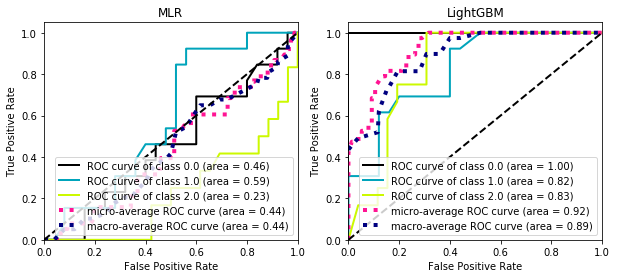

In [22]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_roc(dftest["Label"], pred[["Score.0", "Score.1", "Score.2"]], ax=ax[0])
plot_roc(dftest["Label"], pred2[["Score.0", "Score.1", "Score.2"]], ax=ax[1])
ax[0].set_title("MLR")
ax[1].set_title("LightGBM");